In [2]:
import azureml.core
import logging

print("SDK version:", azureml.core.VERSION)

from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

import os
subscription_id = os.getenv("SUBSCRIPTION_ID", default="52f3cf55-fed4-4f7e-9aca-f3da535a03c1")
resource_group = os.getenv("RESOURCE_GROUP", default="automl_rg")
workspace_name = os.getenv("WORKSPACE_NAME", default="automl_ws")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

try:
    interactive_auth = InteractiveLoginAuthentication(tenant_id="1591aa04-9c2a-4144-9a04-fb8b0d506de5")
    ws = Workspace(subscription_id = subscription_id, 
               resource_group = resource_group, 
               workspace_name = workspace_name,
               auth=interactive_auth)    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded.")
except:
    print("Workspace not accessible.")



SDK version: 1.0.45
Turning diagnostics collection on. 
Workspace configuration succeeded.


In [22]:
dataset_exp = {"defect_camel_1_2":"AutoML_29aecac8-d329-4ead-85e9-55db459752a2"
,"defect_eclipse_2_0":"AutoML_b89e58d1-6878-49b4-9c20-93c9b96cb05b"
,"defect_eclipse_3_0":"AutoML_d551db36-cd0d-4c80-8931-7c3912d47cb2"
,"defect_prop_2":"AutoML_5072b529-0b82-4718-9e82-343bd6bf8aac"
,"defect_xalan_2_6":"AutoML_561e7b85-1240-4bcc-aff3-5c674497ae0a"}

exp_runid = {"defect_camel_1_2":"Automl_defect_camel_1_2"
,"defect_eclipse_2_0":"Automl_defect_eclipse_2_0"
,"defect_eclipse_3_0":"Automl_defect_eclipse_3_0"
,"defect_prop_2":"Automl_defect_prop_2"
,"defect_xalan_2_6":"Automl_defect_xalan_2_6"}



In [28]:
# Load data
def loadData(dataset_name):
    dataset_file_name = dataset_name+'.csv'
    dataset_path_name = os.path.join(os.getcwd(),'data/'+dataset_name+'.csv' )
    import pandas as pd
    df = pd.read_csv(dataset_path_name)
    x_df = df.drop(columns =['target'])
    y_df = df[['target']]
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)
    # flatten y_train to 1d array
    y_train.values.flatten()# flatten y_train to 1d array
    return x_train, x_test, y_train, y_test

In [23]:
from azureml.widgets import RunDetails
from azureml.train.automl.run import AutoMLRun
from azureml.core.experiment import Experiment

a_run_map={}
a_model_map={}

for dataset,exp in exp_runid.items():
    experiment=Experiment(ws, exp)
    remote_run = AutoMLRun(experiment = experiment, run_id =dataset_exp[dataset])
    b_run, b_model = remote_run.get_output()
    a_run_map[dataset]=b_run
    a_model_map[dataset]=b_model
    print('Algorithm: '+b_run.get_properties()['run_algorithm'])




Algorithm: ExtremeRandomTrees
Algorithm: LightGBM
Algorithm: LightGBM
Algorithm: XGBoostClassifier
Algorithm: RandomForest


In [60]:

import eli5
from eli5.sklearn import PermutationImportance

a_important_map={}
for dataset,exp in exp_runid.items():
    b_model = a_model_map[dataset]
    x_train, x_test, y_train, y_test = loadData(dataset)
    perm = PermutationImportance(b_model).fit(x_test, y_test.values)
    a_important_map[dataset]=eli5.show_weights(perm,feature_names  = x_test.columns.tolist())
    print(dataset)

defect_camel_1_2
defect_eclipse_2_0
defect_eclipse_3_0
defect_prop_2
defect_xalan_2_6


In [131]:
import pickle
pickle.dump(a_important_map, open('./a_important_map', 'wb'))


In [61]:
from IPython.display import display, HTML

displayHTML = ''

for dataset,imp in a_important_map.items():
    displayHTML = displayHTML +"<h1>"+dataset.split("defect_")[1]+": "+a_run_map[dataset].get_properties()['run_algorithm']+"</h1>"+imp.data
display(HTML(displayHTML))

Weight,Feature
0.0295 ± 0.0131,cbm
0.0230 ± 0.0191,max_cc
0.0098 ± 0.0217,moa
0.0049 ± 0.0304,npm
0.0016 ± 0.0318,noc
0.0016 ± 0.0191,cbo
0.0016 ± 0.0468,dam
0.0000 ± 0.0274,avg_cc
-0.0016 ± 0.0123,lcom
-0.0033 ± 0.0131,ic


In [ ]:

from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

a_auc_map={}


for dataset,exp in exp_runid.items():
    b_model = a_model_map[dataset]
    x_train, x_test, y_train, y_test = loadData(dataset)

    sample_size = int(y_test.shape[0]*0.1)
    boot_size = 100
    auc_weighted_list=[]
    for ite in range(1,boot_size):
        resample_x, resampel_y = resample(x_test,y_test
                                          #, n_samples=sample_size
                                          , replace=True
                                          , random_state=ite)
        predicted_y = b_model.predict_proba(resample_x)
        auc_weighted=roc_auc_score(resampel_y,predicted_y[:,1],average='weighted')
        if auc_weighted < 0.5: 
            auc_weighted = 1-auc_weighted
        auc_weighted_list.append(auc_weighted)
    print(dataset)
    a_auc_map[dataset]=auc_weighted_list
    
    plt.rcParams["figure.figsize"] = (5, 3)
    fig1, ax1 = plt.subplots()
    ax1.set_title('AML: performance distribution of '+a_run_map[dataset].get_properties()['run_algorithm']+' on '+dataset.split("defect_")[1])
    bp_dict = ax1.boxplot(auc_weighted_list,vert=False)
    for line in bp_dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        text(x, y, round(x,4),
             horizontalalignment='center') # draw above, centered
    #savefig('test.png', bbox_inches='tight')




In [71]:
import pickle
pickle.dump(a_auc_map, open('./a_auc_map', 'wb'))

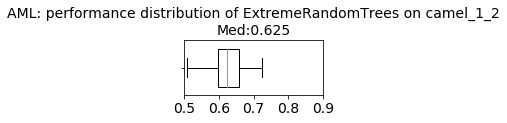

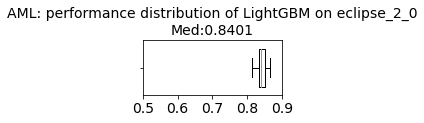

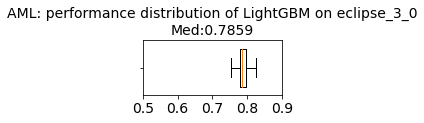

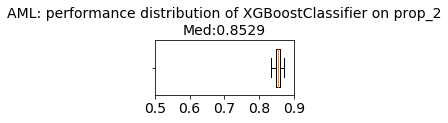

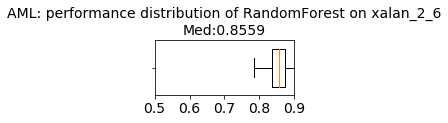

In [103]:

for dataset in exp_runid.keys():
    auc_weighted_list = a_auc_map[dataset]
    plt.rcParams["figure.figsize"] = (2.5, 1)
    fig1, ax1 = plt.subplots()
    title = 'AML: performance distribution of '+a_run_map[dataset].get_properties()['run_algorithm']+' on '+dataset.split("defect_")[1]

    #print(title)
    bp_dict = ax1.boxplot(auc_weighted_list,vert=False,showfliers=False,widths = 0.7)
    plt.xticks(fontsize=14)
    ax1.set_xlim([0.5,0.9])
    ax1.set_yticklabels('')
    ax1.set_title(title+'\n'+'Med:' + str(round(median(auc_weighted_list),4)),fontsize = 14)
    
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    text(x, y+0.2, str(round(x,4),
    #         horizontalalignment='center', fontsize=25) # draw above, centered

In [66]:
a_auc_map.keys()

dict_keys(['defect_camel_1_2', 'defect_eclipse_2_0', 'defect_eclipse_3_0', 'defect_prop_2', 'defect_xalan_2_6'])